# Documentation

Using cv technique, validate the error of the reconstructed data after applying PCA.

Explored on potential factors that could influence mse. As well as examining if there are any relationship between the number of components used and mse.

# Work

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load our X from previous work...

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/UW/sphscAudiogram/audiogram_x.csv')

**Define a function** for cross validating the error between original unseen data and the pca (fitted on training data) reconstructed unseen data.

In [ ]:
'''
Inputs
n_splits: number of splits for CV
n_components: number of principle components to fit
X: data to conduct PCA
scale: whether to standardize the input data or not

Returns a list of mse and the average mse
'''
def cv_pca(n_splits, n_components, X, random_state = 42, shuffle = True, scale = True):
  if scale:
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    # rename the scaled df to X, so the rest of the code in the function doesn't depend of whether X is scaled or not
    X = pd.DataFrame(X_scaled, columns = X.columns)

  # cv: k fold cv object
  cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

  # mse_scores: list of mse scores for each fold of cv
  mse_scores = []

  for train_idx, test_idx in cv.split(X):
    # split X into train and test based on cv assigned indices
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

    # get a pca object with number of components passed from the call of function
    pca = PCA(n_components=n_components)
    # fit pca to train
    pca.fit(X_train)

    # obtain the reconstructed X_test after fitting to the pca
    X_test_transformed = pca.transform(X_test)
    X_test_reconstructed = pca.inverse_transform(X_test_transformed)

    # if scaled, scale X back to original scale
    if scale:
      X_test_reconstructed = scaler.inverse_transform(X_test_reconstructed)
      X_test = scaler.inverse_transform(X_test)

    # calculate mse of reconstructed test set and original test set
    mse = mean_squared_error(X_test, X_test_reconstructed)
    mse_scores.append(mse)

    # get the average mse across all validation
    average_mse = np.mean(mse_scores)

  return mse_scores, average_mse

**Note:** The purpose of using a train and test set is to imitate the real process, when we train a pca based on some training measurements of audiogram, and the X_test mse tells us how much error we produce when our pre-trained pca is used to transform our predictions of pc's to our predictions of the measurements in the unseen audiogram.

**Explore on different parameters**

In [ ]:
# cv of 5 splits, fitting pca with 5 components, with scaling
cv_pca(5, 5, X)

([51.705296600703655,
  48.14517542612731,
  48.25540936843997,
  40.07625638349369,
  41.479360686799254],
 45.93229969311278)

Let's now see the error if we don't standardize the input dataframe.

In [ ]:
# cv of 5 splits, fitting pca with 5 components, without scaling
cv_pca(5, 5, X, False)

([39.92318870005597,
  47.365586498589316,
  48.960403308632095,
  51.13316809518701,
  39.565802186129304],
 45.38962975771874)

**Without age and gender?**

Since age and gender is not part of outcome variable in practice, what if we only examine the samples of the same gender and age range?

In [ ]:
# X_under40_F: audiogram measurements of female under 40
X_under40_F = X[(X['AGE'] < 40) & (X['GENDER_Female'] == 1)].drop(columns = ['AGE', 'GENDER_Female', 'GENDER_Male'])

In [ ]:
X_under40_F.shape

(20, 16)

We have few number of observations for the dimension of the data, this is likely to increase the mse.

In [ ]:
# cv of 5 splits, fitting pca with 5 components, with scaling
cv_pca(5, 5, X_under40_F)

([121.90383981539868,
  47.25623293404746,
  96.1426909441619,
  25.814366292680308,
  15.78665247727881],
 61.380756492713445)

It makes sence the error increases significantly.

Trying for different number of PCA components.

In [ ]:
# mean_mses: list of mean mse obtained from looping through all possible number of pca components
mean_mses = [0]
for i in range(1, len(X.columns)+1):
  # getting the mean mse of 5 folds cv with i components
  mean_mses.append(cv_pca(5, i, X)[1])

In [ ]:
mean_mses = pd.DataFrame(mean_mses)
mean_mses.rename(columns={0: 'MSE'}, inplace=True)

Now let's visualize it.

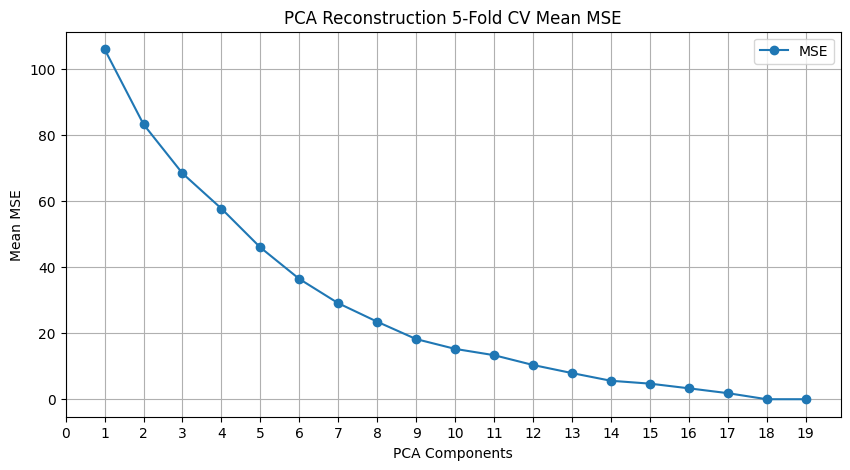

In [ ]:
pd.DataFrame(mean_mses.iloc[1:len(X.columns)+1]).plot(kind='line', style='-o', figsize=(10, 5))
plt.title('PCA Reconstruction 5-Fold CV Mean MSE')
plt.xlabel('PCA Components')
plt.ylabel('Mean MSE')
plt.xticks(ticks=np.arange(0, len(X.columns)+1))
plt.grid(True)

plt.show()

**Observation:** The plot shows no obvious turn, or 'elbow'. The decrease in decreasing rate of the mean MSE is seemingly constant (first derivative linear).

How do we decide how many PCA components we want to use?